## Do it! Natural Language Processing using BERT and GPT - part2
#### 한국어 자연어 처리에 관한 내용을 정리하였습니다. Do it! BERT와 GPT로 배우는 자연어 처리(이기창 지음)을 참고하였습니다.
## 2. 문장을 작은 단위로 쪼개기
### 2.1 토큰화란?
#### 토큰화 : 문장을 토큰 시퀀스로 나누는 과정
#### 토크나이저 : 토큰화를 수행하는 프로그램 ex. 은전한닙(mecab), 꼬꼬마(kkma)
#### 단어 단위 토큰화 -> 어휘 집합의 크기가 너무 커질 수 있음
#### 문자 단위 토큰화 -> 미등록 토큰 문제에서 자유로움, 어휘 집합 크기 제한 가능, 모델의 학습 성능이 좋지 않음
#### 서브워드 단위 토큰화 -> 단어와 문자 단위의 중간 형태(둘의 장점을 취함) ex. BPE

### 2.2 바이트 페어 인코딩이란?
#### 바이트 페어 인코딩(Byte Pair Encoding, BPE) : 정보를 압축하는 알고리즘으로 제안되었으나 자연어 처리 모델에 널리 쓰이는 토큰화 기법. GPT 계열에서 사용
#### BPE는 사전의 크기를 지나치게 늘리지 않는 동시에 데이터 길이를 효율적으로 압축
#### BPE 활용 시 말뭉치에서 자주 나타나는 문자열(서브워드)를 토큰으로 분석하기 때문에 언어에 대한 지식이 필요 하지 않음
#### BPE 절차 : 어휘 집합 구축 -> 토큰화 
#### 프리토크나이즈(pre-tokenizd) : 말뭉치의 모든 문장을 공백으로 분리하여 말뭉치는 준비하는 과정 / 토큰화에 앞서 미리 분석했다는 의미
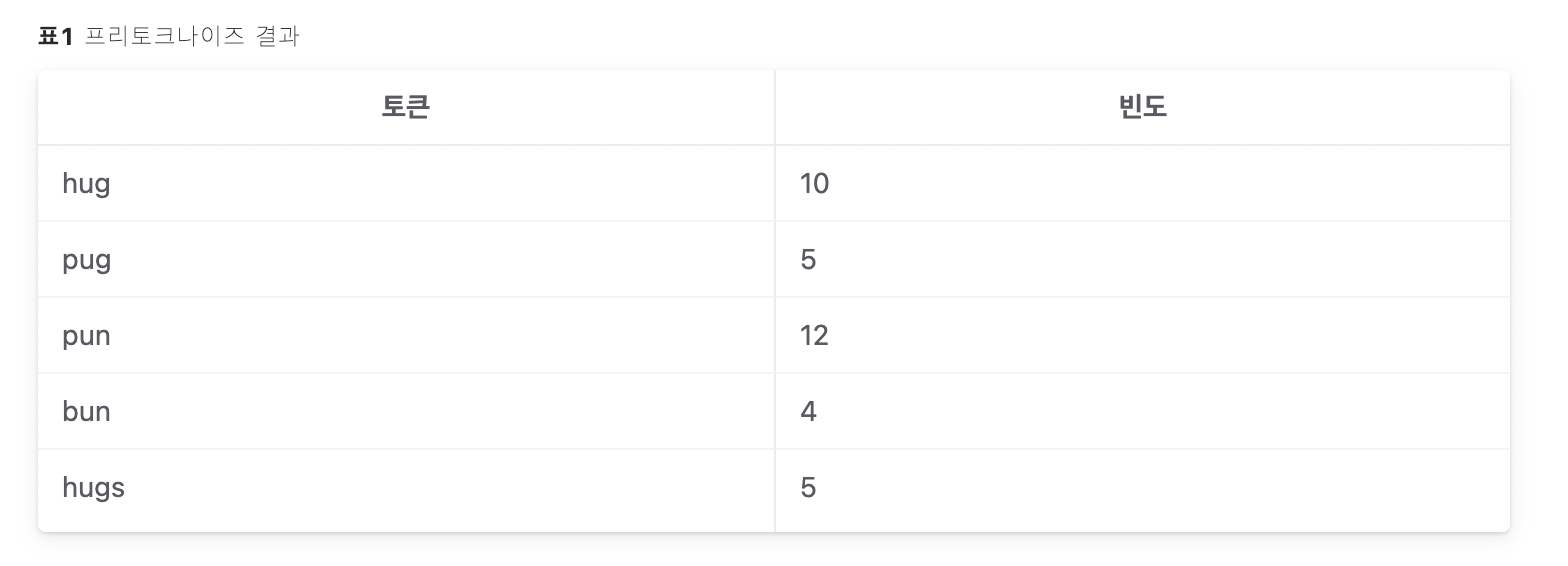
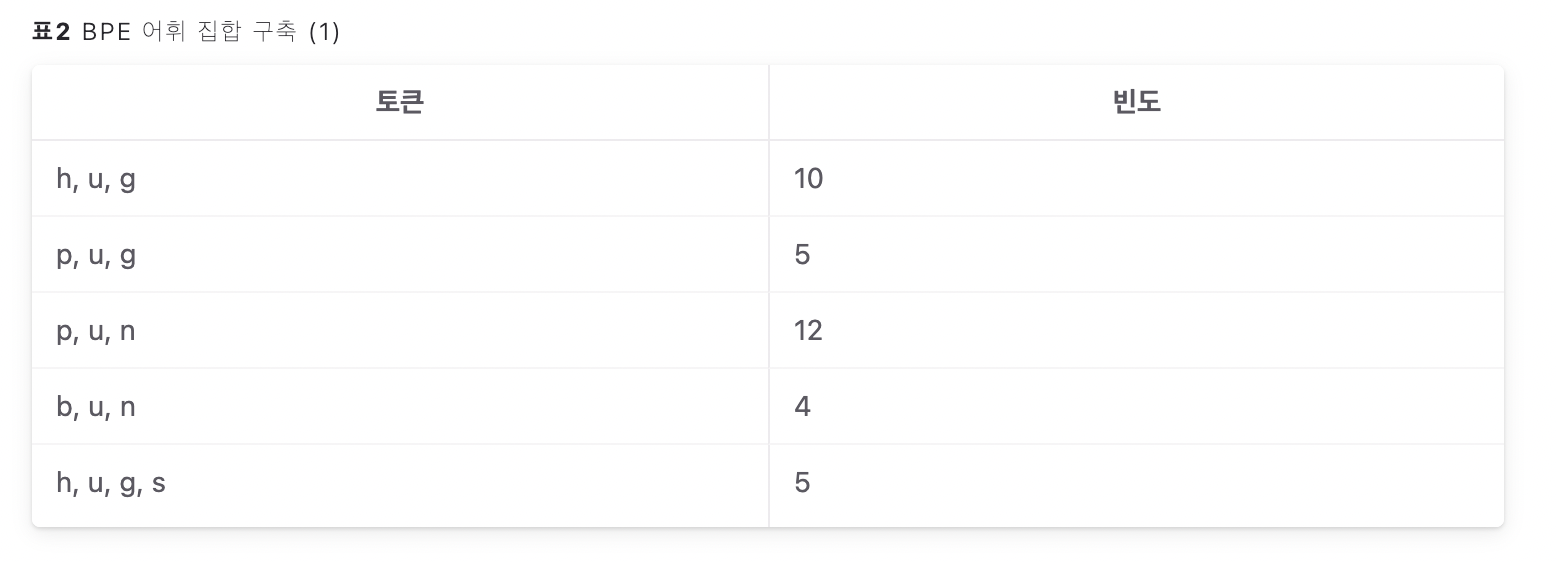
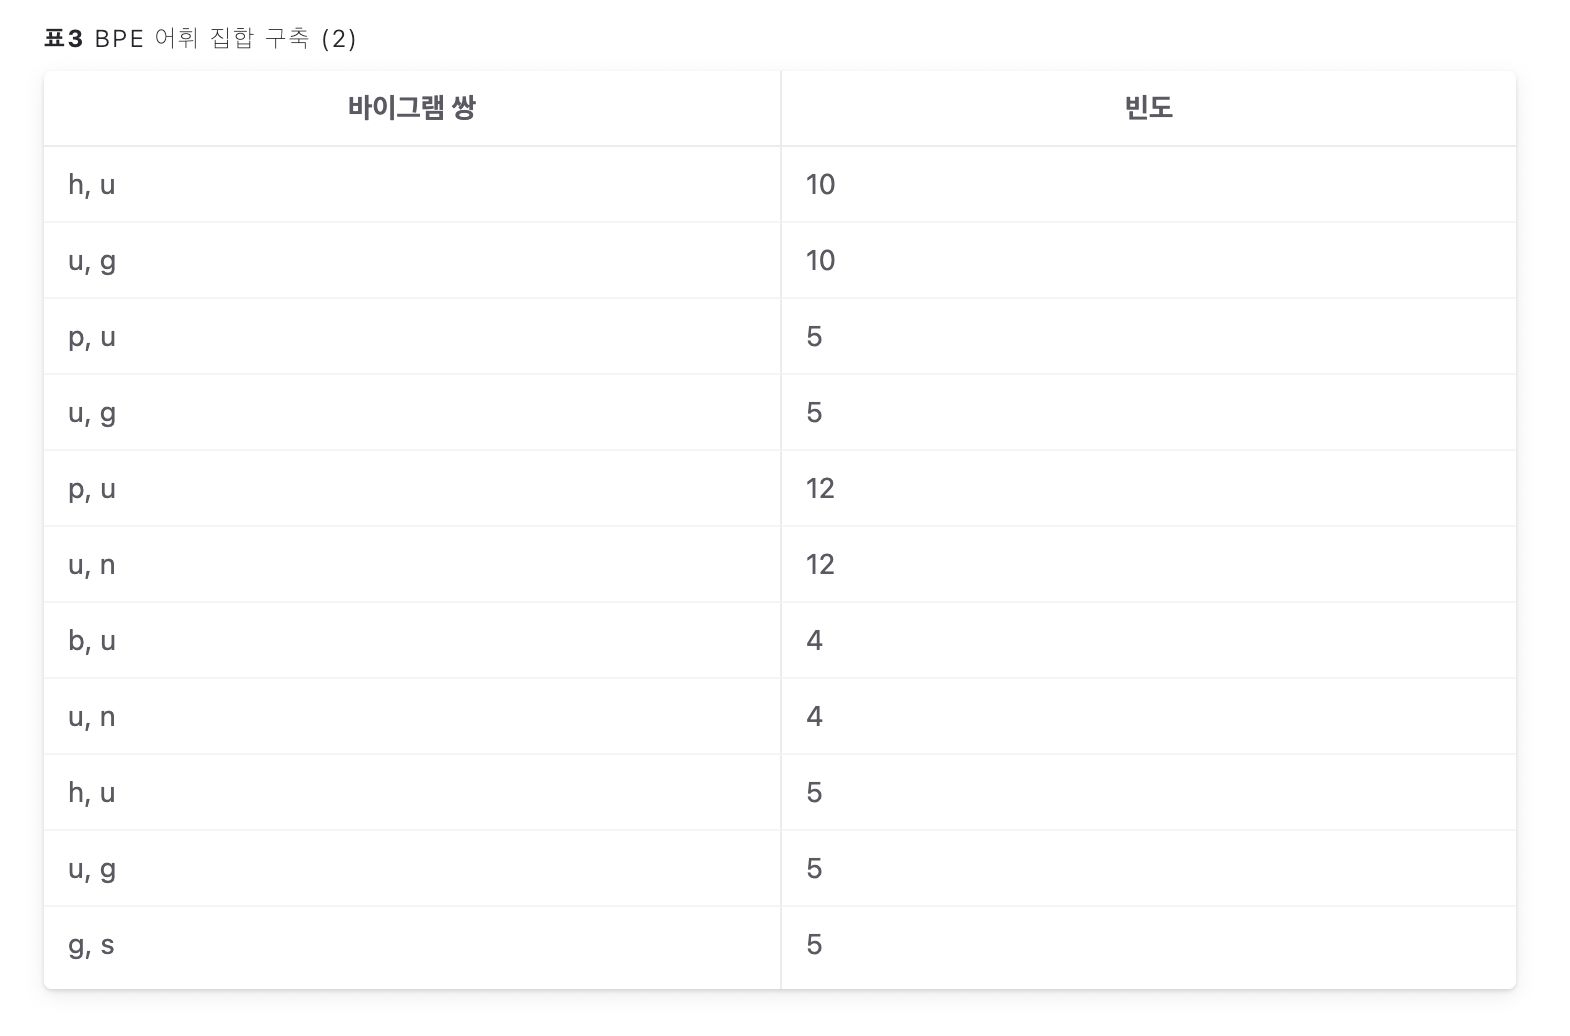
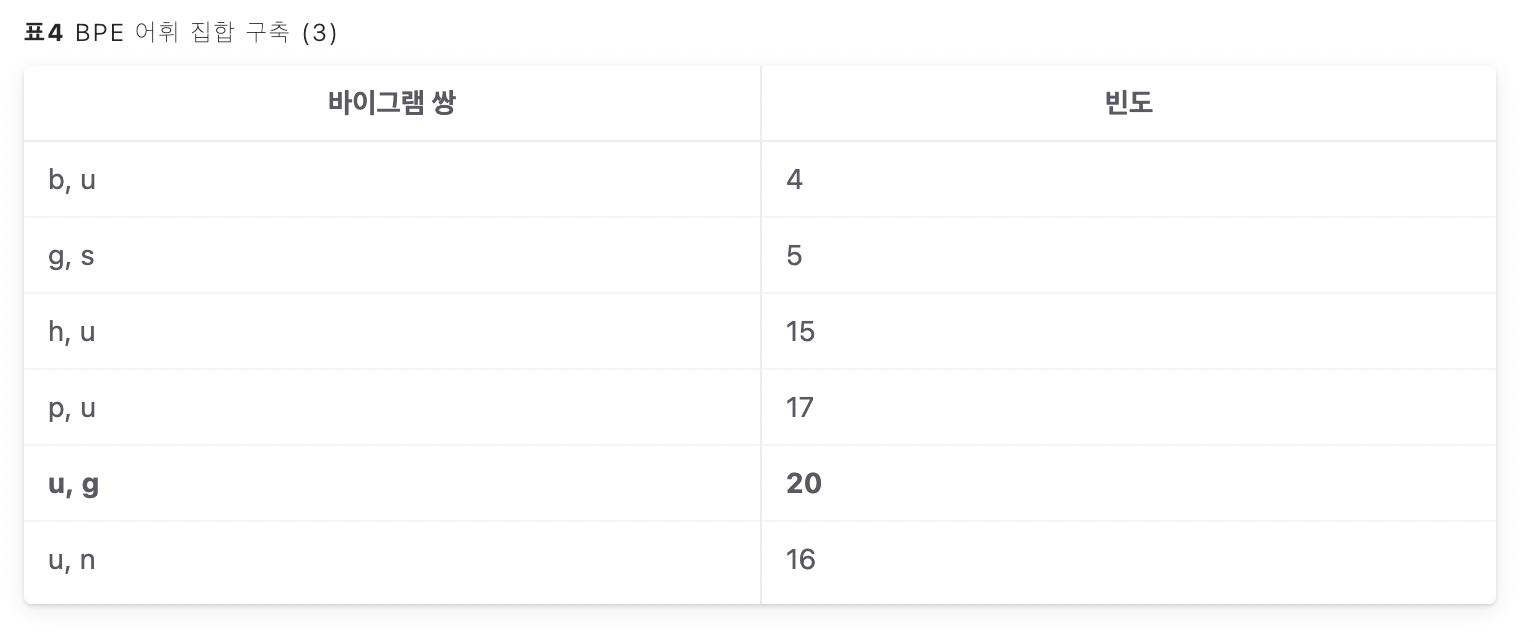
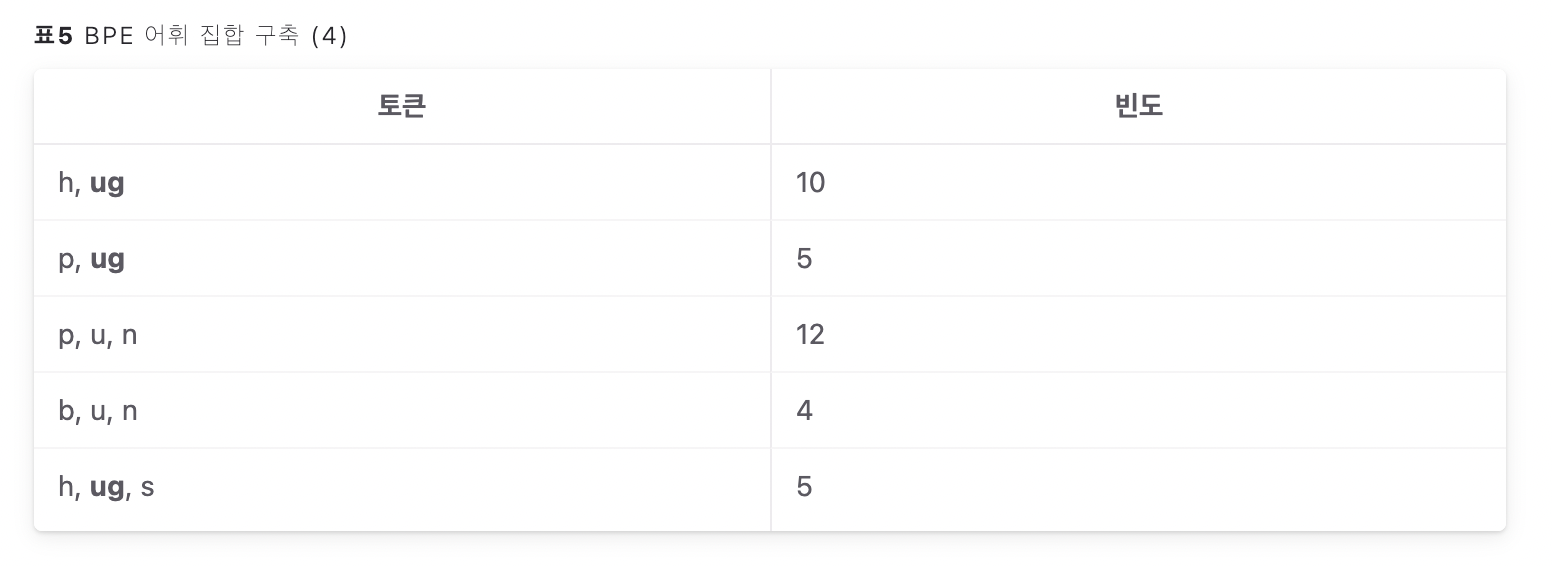
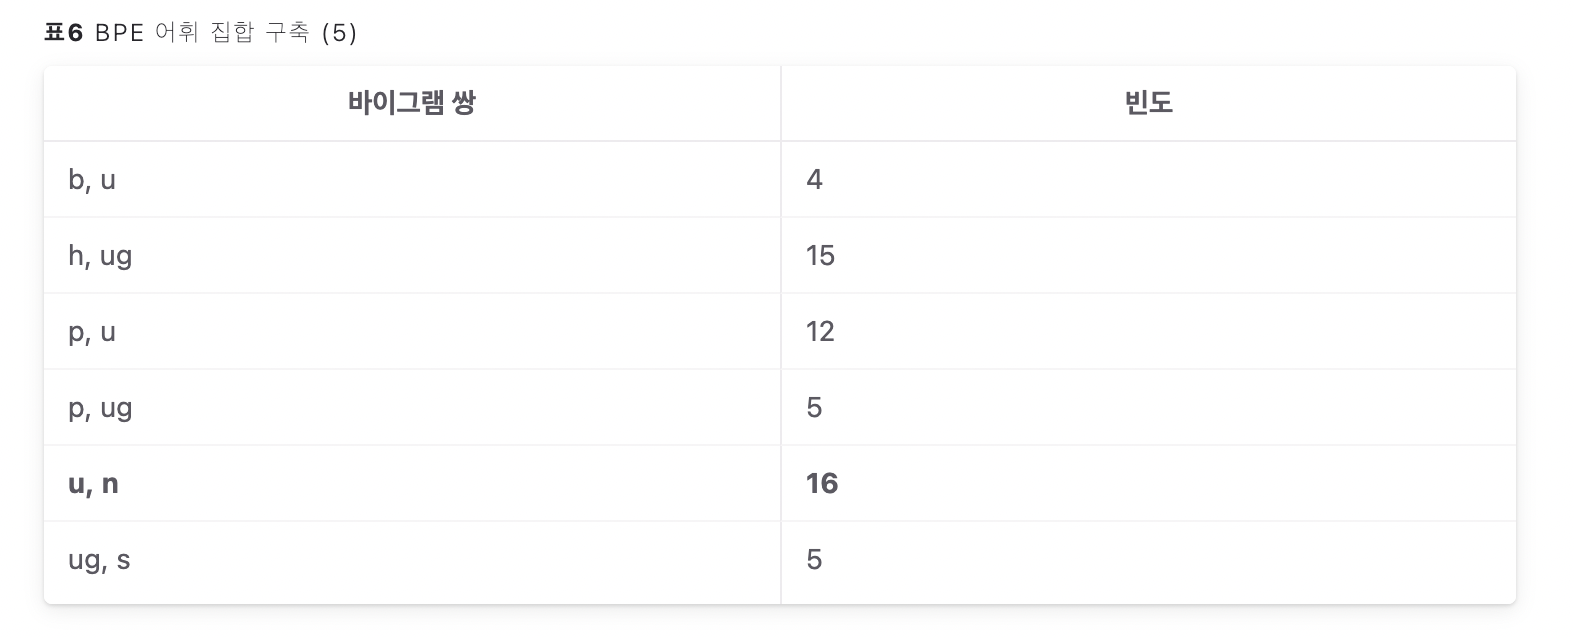
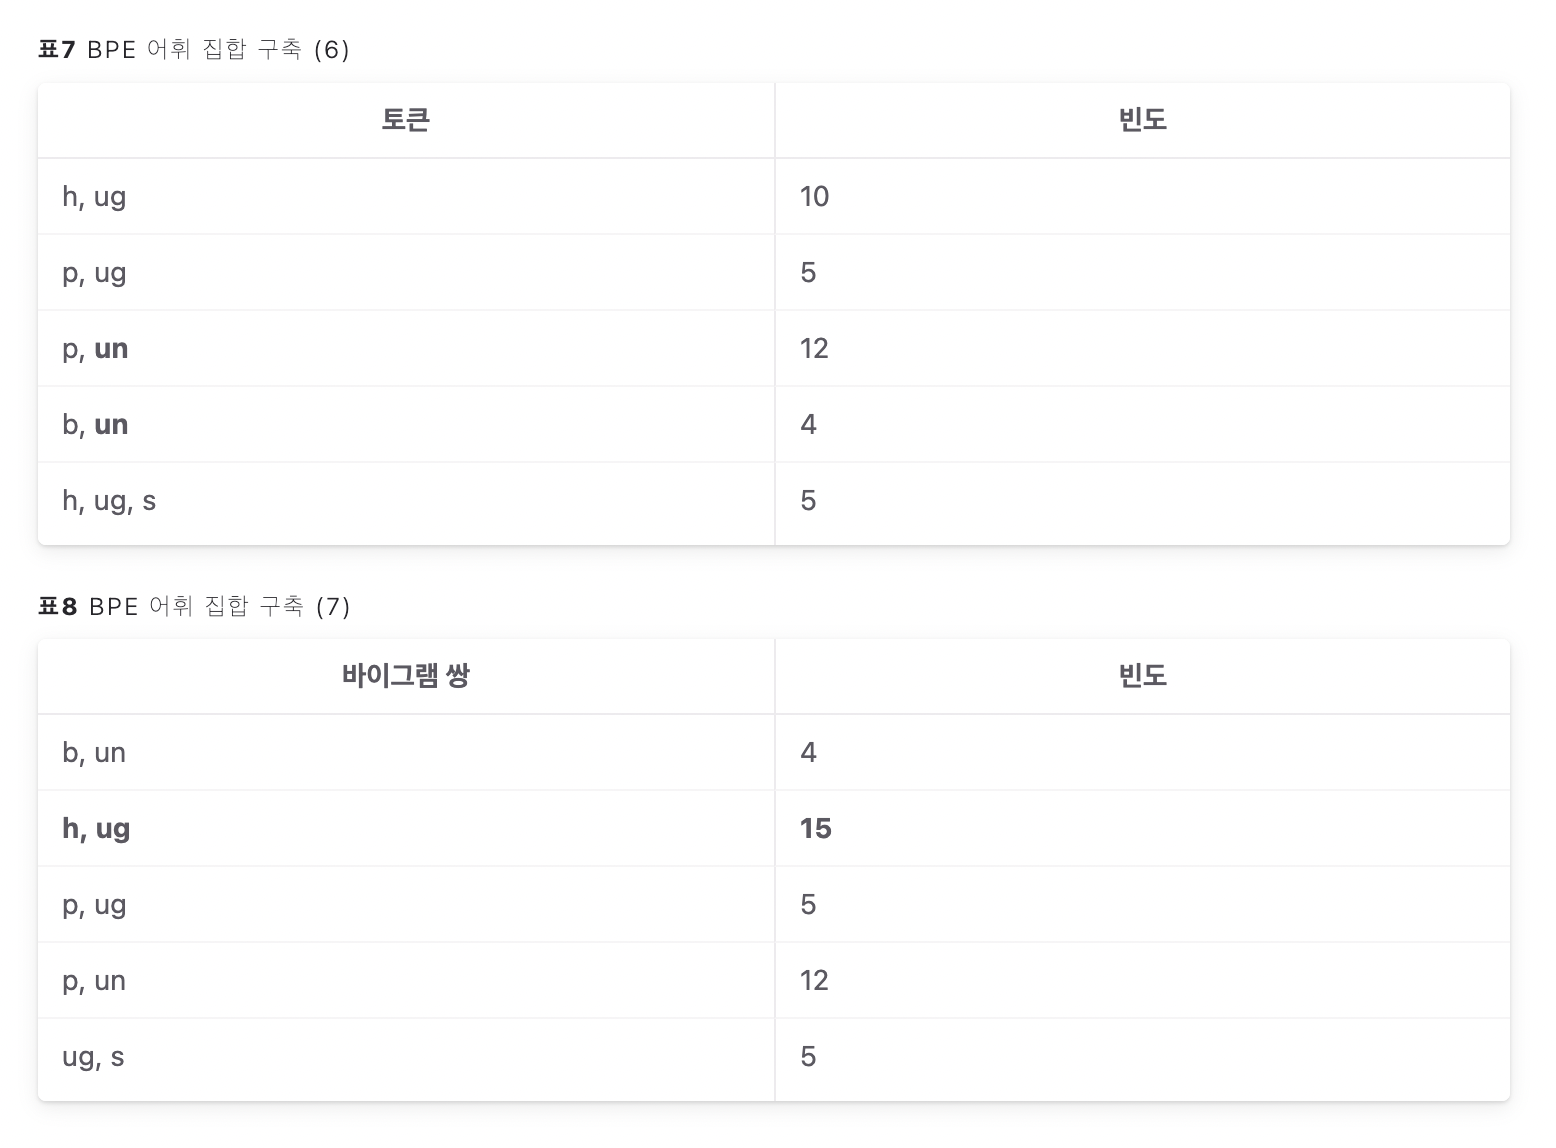

#### BPE 어휘 집합은 사용자가 정한 크기가 될 떄까지 위의 과정을 반복 수행
#### vocab.json : 어휘 집합 구축 결과가 저장 되는 파일
#### merges.txt : 병합 우선순위가 저장 되는 파일
#### 어휘집합(vocab.json)과 병합 우선순위(merges.txt)가 있으면 토큰화 수행 가능
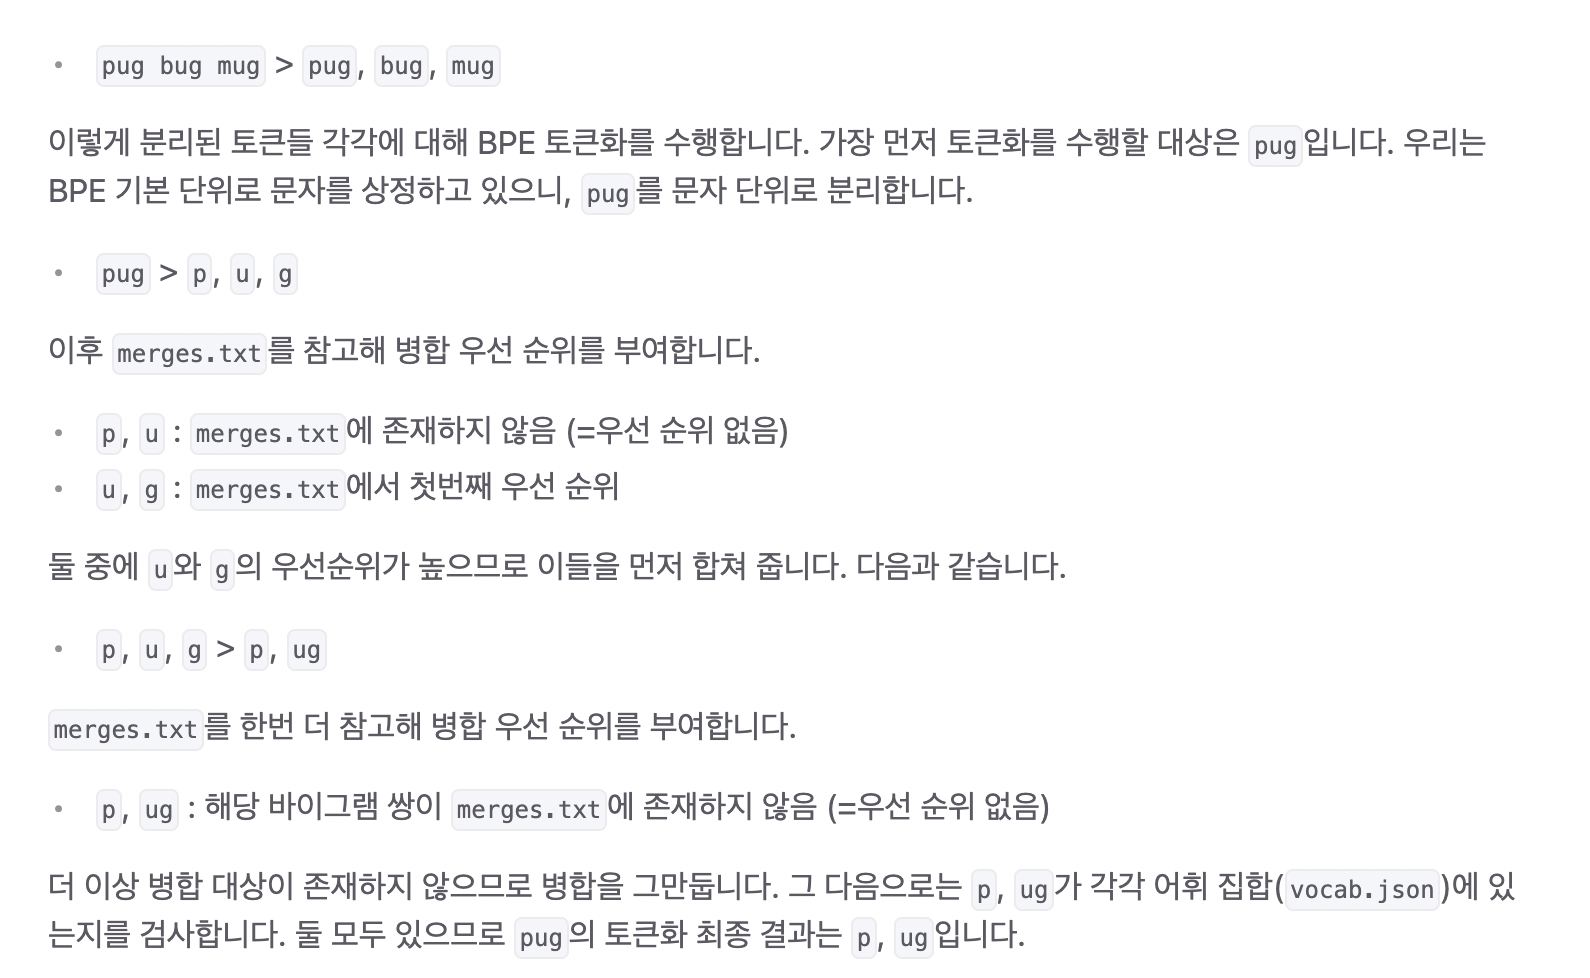

#### 워드피스(wordpiece) : 말뭉치에서 자주 등장하는 문자열을 토큰으로 인식하는 점에서 BPE와 본질적으로 동일
#### 문자열 병합 기준 : BPE - 단순 빈도 / 워드피스 - 말뭉치의 우도를 가장 높이는 쌍
#### 워드피스에서는 병합 후보에 오른 쌍을 미리 병합해보고 잃는 것과 가치 등을 판단한 후 병합 / 병합 대상 전체 후보들 중 아래 계산 값이 가장 높은 쌍을 합침
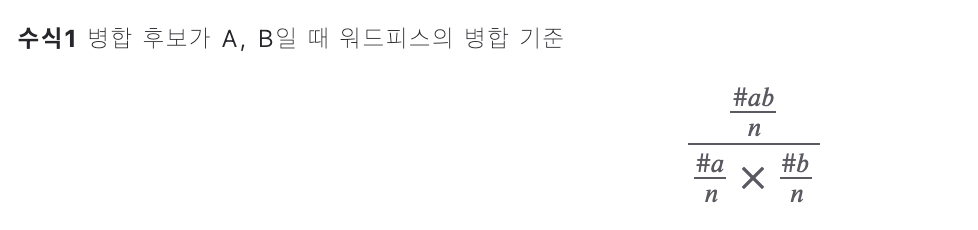

#### 워드피스는 어휘 집합(vocab.txt)만으로 토큰화 / 분석 대상 어절에 어휘 집합에 있는 서브워드가 포함돼 있을 때 해당 서브워드를 어절에서 분리 / 서브워드 후보가 여럿 있을 경우 가장 긴 서브워드를 선택(최장 일치 기준)

### 2.3 어휘 집합 구축하기

In [1]:
#### NSMC 다운로드
from Korpora import Korpora
nsmc = Korpora.load("nsmc", force_download=True)


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : e9t@github
    Repository : https://github.com/e9t/nsmc
    References : www.lucypark.kr/docs/2015-pyconkr/#39

    Naver sentiment movie corpus v1.0
    This is a movie review dataset in the Korean language.
    Reviews were scraped from Naver Movies.

    The dataset construction is based on the method noted in
    [Large movie review dataset][^1] from Maas et al., 2011.

    [^1]: http://ai.stanford.edu/~amaas/data/sentiment/

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/



[nsmc] download ratings_train.txt: 14.6MB [00:02, 6.63MB/s]                            
[nsmc] download ratings_test.txt: 4.90MB [00:00, 5.20MB/s]                            


In [2]:
#### NSMC 전처리
import os
def write_lines(path, lines):
    with open(path, 'w', encoding='utf-8') as f:
        for line in lines:
            f.write(f'{line}\n')

write_lines("train.txt", nsmc.train.get_all_texts())
write_lines("test.txt", nsmc.test.get_all_texts())

In [3]:
#### GPT 토크나이저 구축 -> BPE / 유니코드 바이트 수준(미등록 토큰 문제 해결 가능)으로 어휘집합 구축 후 토큰화 수행
from tokenizers import ByteLevelBPETokenizer
bytebpe_tokenizer = ByteLevelBPETokenizer()
bytebpe_tokenizer.train(files=["train.txt", "test.txt"], vocab_size = 10000, special_tokens=["[PAD]"])
bytebpe_tokenizer.save_model("./part2-bbpe")

['./part2-bbpe/vocab.json', './part2-bbpe/merges.txt']

In [4]:
#### BERT 토크나이저 구축 -> 워드피스
from tokenizers import BertWordPieceTokenizer
wordpiece_tokenizer = BertWordPieceTokenizer(lowercase=False)
wordpiece_tokenizer.train(files=["train.txt", "test.txt"], vocab_size=10000)
wordpiece_tokenizer.save_model("./part2-wordpiece/")

['./part2-wordpiece/vocab.txt']

### 2.4 토큰화하기

In [5]:
#### GPT 토크나이저 선언
from transformers import GPT2Tokenizer
tokenizer_gpt = GPT2Tokenizer.from_pretrained("./part2-bbpe")
tokenizer_gpt.pad_token = "[PAD]"

file ./part2-bbpe/config.json not found


In [8]:
#### GPT 토크나이저로 토큰화하기
sentences = [
    "아 더빙.. 진짜 짜증나네요 목소리",
    "흠..포스터보고 초딩영화줄....오벼연기조차 가볍지 않구나",
    "별루 였다.."
]
tokenized_sentences = [tokenizer_gpt.tokenize(sentence) for sentence in sentences]
tokenized_sentences

[['ìķĦ', 'ĠëįĶë¹Ļ', '..', 'Ġì§Ħì§ľ', 'Ġì§ľì¦ĿëĤĺ', 'ëĦ¤ìļĶ', 'Ġëª©ìĨĮë¦¬'],
 ['íĿł',
  '..',
  'íı¬ìĬ¤íĦ°',
  'ë³´ê³ł',
  'Ġì´ĪëĶ©',
  'ìĺģíĻĶ',
  'ì¤Ħ',
  '....',
  'ìĺ¤',
  'ë²¼',
  'ìĹ°ê¸°',
  'ì¡°ì°¨',
  'Ġê°Ģë³į',
  'ì§Ģ',
  'ĠìķĬ',
  'êµ¬ëĤĺ'],
 ['ë³Ħë£¨', 'Ġìĺ', 'Ģëĭ¤', '..']]

In [11]:
#### GPT 모델 입력 만들기
batch_input = tokenizer_gpt(sentences, padding="max_length", max_length=12, truncation=True)

#### 어휘 집합을 통한 인덱싱 결과
batch_input["input_ids"]

[[334, 2338, 263, 581, 4055, 464, 3808, 0, 0, 0, 0, 0],
 [3693, 263, 2876, 758, 2883, 356, 806, 422, 440, 4143, 875, 2960],
 [4957, 451, 3653, 263, 0, 0, 0, 0, 0, 0, 0, 0]]

In [12]:
#### 일반 토큰과 패딩 토큰 구분 결과 - attention mask
batch_input["attention_mask"]

[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]

In [13]:
#### BERT 토크나이저 선언
from transformers import BertTokenizer
tokenizer_bert = BertTokenizer.from_pretrained('./part2-wordpiece/', do_lower_case = False)

file ./part2-wordpiece/config.json not found


In [14]:
#### BERT 토크나이저로 토큰화하기
sentences = [
    "아 더빙.. 진짜 짜증나네요 목소리",
    "흠..포스터보고 초딩영화줄....오벼연기조차 가볍지 않구나",
    "별루 였다.."
]
tokenized_sentences = [tokenizer_bert.tokenize(sentence) for sentence in sentences]
tokenized_sentences

[['아', '더빙', '.', '.', '진짜', '짜증나', '##네요', '목소리'],
 ['흠',
  '.',
  '.',
  '포스터',
  '##보고',
  '초딩',
  '##영화',
  '##줄',
  '.',
  '.',
  '.',
  '.',
  '오',
  '##벼',
  '##연기',
  '##조차',
  '가볍',
  '##지',
  '않',
  '##구나'],
 ['별루', '였다', '.', '.']]

In [15]:
#### BERT 모델 입력 만들기
batch_inputs = tokenizer_bert(sentences, padding='max_length', max_length=12, truncation=True)

#### 토큰 인덱스 시퀀스
batch_inputs['input_ids']

[[2, 621, 2631, 16, 16, 1993, 3678, 1990, 3323, 3, 0, 0],
 [2, 997, 16, 16, 2609, 2045, 2796, 1981, 1189, 16, 16, 3],
 [2, 3274, 9507, 16, 16, 3, 0, 0, 0, 0, 0, 0]]

In [16]:
#### attention mask
batch_inputs['attention_mask']

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]]

In [17]:
#### 세그먼트에 해당하는 것 -> BERT 모델 특징 : 기본적으로 문서(혹은 문장) 2개를 입력으로 받음, 2개의 입력값을 구분하는 결과
batch_inputs['token_type_ids']

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]